# H chain QEM

## Set experiment parameters

In [1]:
ibm_computer: str = "ibm_fez"
qubits = list(range(0, 14))  # [153, 152, 151, 150, 149, 148, 147, 146, 145, 144, 143, 136, 123, 124]
nshots: int = 20_000

len(qubits)

14

## Setup

In [2]:
from typing import Tuple

import matplotlib.pyplot as plt; plt.rcParams.update({"font.family": "serif"})
import networkx as nx
import numpy as np
import pickle

from cirq.contrib.qasm_import import circuit_from_qasm
import openfermion as of

import qiskit
from qiskit import qasm2, qasm3
from qiskit_aer import AerSimulator
import qiskit_ibm_runtime
from qiskit_ibm_runtime import SamplerV2 as Sampler

from mitiq.interface.mitiq_qiskit import to_qiskit

### Helper functions

In [3]:
def pickle_load(file_name):
    my_file = open(file_name, "rb")
    data = pickle.load(my_file)
    my_file.close()
    return data

## Read in the Hamiltonian and ansatz circuit

In [4]:
hamiltonian = pickle_load("./H7_r=3_hamiltonian")
circuit = qasm3.load("./circuit")
# layout = pickle_load("./layout")

In [5]:
hamiltonian = of.get_fermion_operator(hamiltonian)

In [6]:
len(hamiltonian.terms)

4855

In [7]:
hamiltonian.compress(0.1)

In [8]:
len(hamiltonian.terms)

67

In [9]:
hamiltonian = of.jordan_wigner(hamiltonian)

In [10]:
hamiltonian = of.qubit_operator_to_pauli_sum(hamiltonian)

In [11]:
print(f"Hamiltonian acts on {len(hamiltonian.qubits)} qubit(s) and has {len(hamiltonian)} Pauli term(s).")

Hamiltonian acts on 14 qubit(s) and has 34 Pauli term(s).


In [12]:
print(hamiltonian)

-4.169*I+0.368*Z(q(0))+0.368*Z(q(1))+0.357*Z(q(2))+0.357*Z(q(3))+0.351*Z(q(4))+0.351*Z(q(5))+0.422*Z(q(6))+0.422*Z(q(7))+0.344*Z(q(8))+0.344*Z(q(9))+0.343*Z(q(10))+0.343*Z(q(11))+0.351*Z(q(12))+0.351*Z(q(13))+0.058*Z(q(0))*Z(q(1))+0.059*Z(q(0))*Z(q(12))+0.059*Z(q(0))*Z(q(13))+0.059*Z(q(1))*Z(q(12))+0.059*Z(q(1))*Z(q(13))+0.055*Z(q(2))*Z(q(3))+0.056*Z(q(2))*Z(q(10))+0.056*Z(q(2))*Z(q(11))+0.056*Z(q(3))*Z(q(10))+0.056*Z(q(3))*Z(q(11))+0.052*Z(q(4))*Z(q(5))+0.052*Z(q(4))*Z(q(8))+0.052*Z(q(4))*Z(q(9))+0.052*Z(q(5))*Z(q(8))+0.052*Z(q(5))*Z(q(9))+0.063*Z(q(6))*Z(q(7))+0.052*Z(q(8))*Z(q(9))+0.057*Z(q(10))*Z(q(11))+0.059*Z(q(12))*Z(q(13))


In [13]:
print(circuit.count_ops())

OrderedDict([('rz', 102), ('cx', 92), ('s', 46), ('sx', 42), ('x', 14), ('h', 7), ('barrier', 7)])


In [14]:
circuit.draw(fold=-1)

░                                                                                                                                                                  ░                                                                                                                                                   ░                                                                                                                                                                                                                                      ░                                                                                                                                                                                                                                       ░                                                                                                                                                                                                                                                                                                                            ░    ┌───┐   ┌───┐            ┌───┐┌──────────┐                                                                                                                                                                                                                                                            ░ 
 0 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░────┤ S ├───┤ H ├──────■─────┤ X ├┤ Rz(-π/2) ├────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░─
                                                                                                                                                                                      ░                                                                                                                                                                  ░                                                                                                                                                   ░                                                                                                                                                                                                                                      ░                                                                                                                                                                                                                                       ░    ┌───┐   ┌───┐            ┌───┐┌──────────┐                             

In [15]:
circuit = qiskit.transpiler.passes.RemoveBarriers()(circuit)

## Connect to Qiskit runtime service

In [18]:
service = qiskit_ibm_runtime.QiskitRuntimeService() # This assumes a saved account.
computer = service.backend(ibm_computer)
sampler = Sampler(computer)

## Run experiment

In [19]:
compiled = qiskit.transpile(
    circuit,
    backend=computer,
    initial_layout=qubits,
    optimization_level=3,
)
compiled.draw(fold=-1, idle_wires=False)

global phase: 5π/4
                                                                         ┌────────┐   ┌────┐  ┌───────┐                                                                                                                                                                                                                                                            ┌────┐   ┌───────┐            ┌────┐                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
 <qiskit.circuit.quantumregister.Qubit object at 0x7fa42b901680> -> 0 ───┤ Rz(-π) ├───┤ √X ├──┤ Rz(π) ├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────■──────────┤ √X ├───┤ Rz(π) ├─────■──────┤ √X ├───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                                         ├────────┤   ├────┤  ├───────┤                                                                                                                                                                                                             ┌────┐ ┌───────┐                    │          ├────┤   ├───────┤     │      └────┘                                       ┌────┐ ┌───────┐   ┌────┐                                                                                                                                                                                                                                                                                                                                                                                                               
 <qiskit.circuit.quantumregister.Qubit object at 0x7fa42b901700> -> 1 ───┤ Rz(-π) ├───┤ √X ├──┤ Rz(π) ├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────■───────┤ √X ├─┤ Rz(π) ├───────■────────────■──────────┤ √X ├───┤ Rz(π) ├─────■─────────────────────────────────────────────■─────┤ √X ├─┤ Rz(π) ├─■─┤ √X ├───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                                         ├────────┤   ├────┤  ├───────┤                                                                                                                                                        ┌────┐      ┌───────┐                        │       ├────┤ ├───────┤       │                       └────┘   └───────┘                              ┌────┐ ┌───────┐     │     ├────┤ ├───────┤ │ └────┘  ┌────┐  ┌───────┐   ┌────┐                                                                              

In [20]:
compiled.count_ops()

OrderedDict([('sx', 157), ('rz', 152), ('cz', 90), ('x', 3)])

In [21]:
def get_measured_zz_circuit(
    circuit: qiskit.QuantumCircuit,
    qubit1_index: int = 2,
    qubit2_index: int = 3,
    creg_name: str = "meas",
) -> Tuple[qiskit.QuantumCircuit, qiskit.ClassicalRegister]:
    to_run = circuit.copy()
    creg = qiskit.ClassicalRegister(2, name=creg_name)
    to_run.add_register(creg)
    to_run.barrier()
    to_run.measure(to_run.qubits[qubit1_index], creg[0])
    to_run.measure(to_run.qubits[qubit2_index], creg[1])
    return to_run

In [22]:
to_run = get_measured_zz_circuit(compiled)

In [23]:
to_run.draw(fold=-1, idle_wires=False)

global phase: 5π/4
                                                                         ┌────────┐   ┌────┐  ┌───────┐                                                                                                                                                                                                                                                            ┌────┐   ┌───────┐            ┌────┐                                                                                                                                                                                                                                                                                                                                                                                                                                                                                ░       
 <qiskit.circuit.quantumregister.Qubit object at 0x7fa42b901680> -> 0 ───┤ Rz(-π) ├───┤ √X ├──┤ Rz(π) ├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────■──────────┤ √X ├───┤ Rz(π) ├─────■──────┤ √X ├────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░───────
                                                                         ├────────┤   ├────┤  ├───────┤                                                                                                                                                                                                             ┌────┐ ┌───────┐                    │          ├────┤   ├───────┤     │      └────┘                                       ┌────┐ ┌───────┐   ┌────┐                                                                                                                                                                                                                                                                                                                                                                                                                ░       
 <qiskit.circuit.quantumregister.Qubit object at 0x7fa42b901700> -> 1 ───┤ Rz(-π) ├───┤ √X ├──┤ Rz(π) ├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────■───────┤ √X ├─┤ Rz(π) ├───────■────────────■──────────┤ √X ├───┤ Rz(π) ├─────■─────────────────────────────────────────────■─────┤ √X ├─┤ Rz(π) ├─■─┤ √X ├────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░───────
                                                                         ├────────┤   ├────┤  ├───────┤                                                                                                                                                        ┌────┐      ┌───────┐                        │       ├────┤ ├───────┤       │                       └────┘   └───────┘                              ┌────┐ ┌───────┐     │     ├────┤ ├───────┤ │ └────┘  ┌────┐  ┌───────┐   ┌────┐                                          

## Noiseless result

In [24]:
job = AerSimulator().run(to_run, shots=nshots)

In [25]:
counts = {np.binary_repr(int(z, 16), 2): count for z, count in job.result().data().get("counts").items()}
counts

{'01': 9705, '10': 10295}

In [26]:
exp_zz_ideal = sum(
    count * (-1) ** sum(map(int, bitstring)) for bitstring, count in counts.items()
) / nshots
exp_zz_ideal

-1.0

## Noisy result

In [27]:
# job = sampler.run([to_run], shots=nshots)
job = service.job("d1vvr4gkchbs73ca903g")

In [28]:
all_counts = [result.data.meas.get_counts() for result in job.result()]

In [29]:
all_counts

[{'11': 1366, '10': 8400, '01': 8278, '00': 1956}]

In [30]:
exp_zz = sum(
    count * (-1) ** sum(map(int, bitstring)) for bitstring, count in all_counts[0].items()
) / nshots
exp_zz

-0.6678

## With dynamical decoupling

In [31]:
sampler_dd = Sampler(computer)
sampler_dd.options.dynamical_decoupling.enable = True
sampler_dd.options.dynamical_decoupling.sequence_type = "XpXm"

In [32]:
# job_dd = sampler_dd.run([to_run], shots=nshots)
job_dd = service.job("d1vvt1okchbs73ca920g")

In [33]:
all_counts_dd = [result.data.meas.get_counts() for result in job_dd.result()]

In [34]:
exp_zz_dd = sum(
    count * (-1) ** sum(map(int, bitstring)) for bitstring, count in all_counts_dd[0].items()
) / nshots
exp_zz_dd

-0.6841

## With readout error mitigation

In [35]:
from qiskit_experiments.library import LocalReadoutError

In [37]:
experiment = LocalReadoutError(qubits)
result = experiment.run(computer)

In [ ]:
mitigator = result.analysis_results("Local Readout Mitigator", dataframe=True).iloc[0].value

In [36]:
mitigator.qubits

NameError: name 'mitigator' is not defined

In [64]:
mitigator.mitigation_matrix(qubits=0)

array([[ 1.00200552, -0.02481825],
       [-0.00200552,  1.02481825]])

In [66]:
all_counts[0]

{'11': 1366, '10': 8400, '01': 8278, '00': 1956}

In [69]:
mitigator.quasi_probabilities?

Signature:
mitigator.quasi_probabilities(
    data: qiskit.result.counts.Counts,
    qubits: Optional[List[int]] = None,
    clbits: Optional[List[int]] = None,
    shots: Optional[int] = None,
) -> qiskit.result.distributions.quasi.QuasiDistribution
Docstring:
Compute mitigated quasi probabilities value.

Args:
    data: counts object
    qubits: qubits the count bitstrings correspond to.
    clbits: Optional, marginalize counts to just these bits.
    shots: Optional, the total number of shots, if None shots will
        be calculated as the sum of all counts.

Returns:
    QuasiDistribution: A dictionary containing pairs of [output, mean] where "output"
        is the key in the dictionaries,
        which is the length-N bitstring of a measured standard basis state,
        and "mean" is the mean of non-zero quasi-probability estimates.

Raises:
    QiskitError: if qubit and clbit kwargs are not valid.
File:      ~/prof/work/wellcome/envuse/lib/python3.10/site-packages/qiskit_exper

In [68]:
mitigator.quasi_probabilities(all_counts[0], qubits=[2, 3])

QiskitError: 'indices must be in range [0, 1].'

In [ ]:
def apply_rem(counts: dict[str, int], mitigator: "qiskit_experiments.LocalReadoutMitigator") -> dict[str, int]:
    mitigated_quasi_probs = mitigator.quasi_probabilities(counts)
    mitigated_probs = (mitigated_quasi_probs.nearest_probability_distribution().binary_probabilities())
    return {k: round(v * nshots) for k, v in mitigated_probs.items()}

In [58]:
mitigator.quasi_probabilities(all_counts[0])

QiskitError: 'indices must be in range [0, 1].'

In [ ]:
all_counts_rem = [apply_rem(counts, mitigator) for counts in all_counts]

In [ ]:
all_counts_dd_rem = [apply_rem(counts, mitigator) for counts in all_counts_dd]
survival_probs_dd_rem = [counts.get("0" * len(qubits), 0) / sum(counts.values()) for counts in all_counts_dd_rem]

In [ ]:
plt.semilogy(depths, survival_probs, "--o", ms=10, mec="black", alpha=0.5, label="Physical")
plt.semilogy(depths, survival_probs_dd, "--o", ms=10, mec="black", alpha=0.5, label="DD")
plt.semilogy(depths, survival_probs_rem, "--o", ms=10, mec="black", alpha=0.5, label="REM")
plt.semilogy(depths, survival_probs_dd_rem, "--o", ms=10, mec="black", alpha=0.5, label="DD + REM")
plt.xlabel("Depth")
plt.ylabel("Survival probability")
plt.legend()
plt.title(f"Loschmidt echo tests on {ibm_computer} qubits " + "-".join(map(str, qubits)));

## With ZNE

In [35]:
from mitiq import zne

In [36]:
qasm2_circuit = qasm2.dumps(compiled)

compiled_cirq = circuit_from_qasm(qasm2_circuit.replace("qregless", "q"))

In [37]:
scale_factors = [1, 3, 5]

In [38]:
scaled_circuits_cirq = [zne.scaling.fold_global(compiled_cirq, scale_factor) for scale_factor in scale_factors]

In [39]:
scaled_circuits = [to_qiskit(circuit) for circuit in scaled_circuits_cirq]
scaled_circuits = qiskit.transpile(
    scaled_circuits,
    backend=computer,
    initial_layout=qubits,
    optimization_level=0,
)

In [40]:
to_run_scaled = [get_measured_zz_circuit(scaled_circuit) for scaled_circuit in scaled_circuits]

In [41]:
to_run_scaled[2].draw(fold=-1, idle_wires=False)

global phase: π
              ┌────────┐   ┌────┐  ┌───────┐                                                                                                                                                                                                                                                            ┌────┐   ┌───────┐            ┌────┐ ┌─────────┐┌─────────┐  ┌────┐ ┌─────────┐┌─────────┐                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        ┌────────┐┌─────────┐┌─────────┐   ┌────┐  ┌─────────┐┌─────────┐            ┌────────┐┌─────────┐┌─────────┐   ┌────┐  ┌─────────┐┌─────────┐ ┌───────┐  ┌────────┐   ┌────┐   ┌───────┐                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        ┌────┐   ┌───────┐            ┌────┐ ┌─────────┐┌─────────┐  ┌────┐ ┌─────────┐┌─────────┐                                                                                                                                                                                                                                                                                                                                                                                                                                                           

In [42]:
# job_zne = sampler.run(to_run_scaled, shots=nshots)
job_zne = service.job("d1vvtd1mr05s73a71lbg")

In [43]:
all_counts_zne = [result.data.meas.get_counts() for result in job_zne.result()]

In [44]:
exp_zz_vals = [
    sum(
        count * (-1) ** sum(map(int, bitstring)) for bitstring, count in counts.items()
    ) / nshots
    for counts in all_counts_zne
]
exp_zz_vals

[-0.7076, -0.4915, -0.2901]

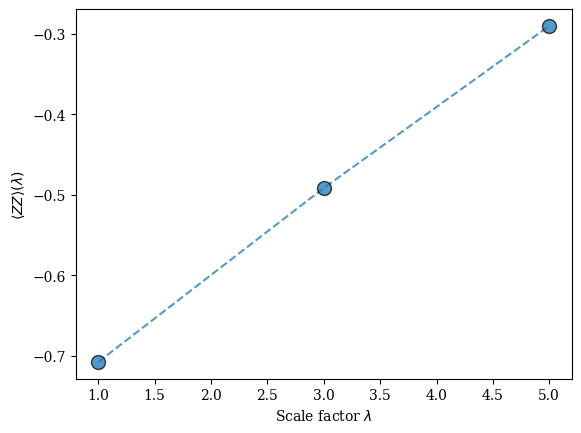

In [45]:
plt.plot(scale_factors, exp_zz_vals, "--o", ms=10, mec="black", alpha=0.75)
plt.xlabel(r"Scale factor $\lambda$")
plt.ylabel(rf"$\langle ZZ \rangle (\lambda) $");

In [46]:
exp_zz_zne = zne.inference.LinearFactory.extrapolate(
    scale_factors,
    exp_zz_vals,
    # order=2,
)
exp_zz_zne

-0.8095249999999996

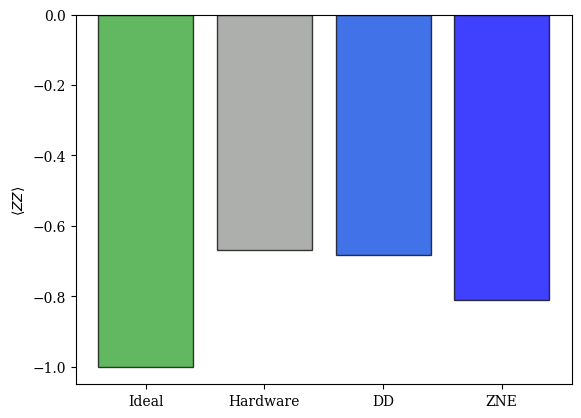

In [56]:
vals = [exp_zz_ideal, exp_zz, exp_zz_dd, exp_zz_zne]

plt.bar(range(len(vals)), vals, tick_label=["Ideal", "Hardware", "DD", "ZNE"], color=["tab:green", "xkcd:grey", "xkcd:blue", "blue"], edgecolor="black", alpha=0.75)
plt.ylabel(r"$\langle ZZ \rangle$");
# plt.savefig("hchain_qem_v0.pdf")